<a href="https://colab.research.google.com/github/Nanungi/Prediction-of-Product-Sales/blob/main/WFP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Deep learning tools

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config
set_config(transform_output='pandas')


#Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

#Sci-kit Learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')


In [ ]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [ ]:
#loading data
path='/content/drive/MyDrive/Data/wfp_food_prices_uga.csv'
df=pd.read_csv(path)
df.head()

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362


In [ ]:
#drop row 0
df = df.drop(0)
df

,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.4,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.4,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362
5,2006-02-15,Busia,Samia-bugwe,Busia,0.467,34.09,cereals and tubers,Maize,KG,actual,Wholesale,UGX,296.59,0.1639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23250,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,non-food,Sanitary pads,Packet,actual,Retail,UGX,2958.0,0.7858
23251,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,non-food,Underwear,Unit,actual,Retail,UGX,1500.0,0.3985
23252,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,oil and fats,Oil (vegetable),L,actual,Retail,UGX,6625.0,1.7601
23253,2024-05-15,Yumbe,Aringa,Bidibidi (refugee settlement),3.36217471,31.35196642,pulses and nuts,Beans,KG,actual,Retail,UGX,4450.0,1.1822


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23254 entries, 1 to 23254
Data columns (total 14 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   date       object
 1   admin1     object
 2   admin2     object
 3   market     object
 4   latitude   object
 5   longitude  object
 6   category   object
 7   commodity  object
 8   unit       object
 9   priceflag  object
 10  pricetype  object
 11  currency   object
 12  price      object
 13  usdprice   object
dtypes: object(14)
memory usage: 2.5+ MB


#changing datatypes

In [ ]:
#changing datatypes
df['price'] = pd.to_numeric(df['price'])
df['price']


1         298.40
2         345.42
3        1013.40
4         247.76
5         296.59
          ...   
23250    2958.00
23251    1500.00
23252    6625.00
23253    4450.00
23254    2328.00
Name: price, Length: 23254, dtype: float64

In [ ]:
df['usdprice'] = pd.to_numeric(df['usdprice'])
df['usdprice']

1        0.1641
2        0.1900
3        0.5573
4        0.1362
5        0.1639
          ...  
23250    0.7858
23251    0.3985
23252    1.7601
23253    1.1822
23254    0.6185
Name: usdprice, Length: 23254, dtype: float64

In [ ]:
df['latitude'] = pd.to_numeric(df['latitude'])
df['latitude']

1        0.467000
2        0.322805
3        0.322805
4        2.235000
5        0.467000
           ...   
23250    3.362175
23251    3.362175
23252    3.362175
23253    3.362175
23254    3.362175
Name: latitude, Length: 23254, dtype: float64

In [ ]:
df['longitude'] = pd.to_numeric(df['longitude'])
df['longitude']

1        34.090000
2        32.574841
3        32.574841
4        32.909722
5        34.090000
           ...    
23250    31.351966
23251    31.351966
23252    31.351966
23253    31.351966
23254    31.351966
Name: longitude, Length: 23254, dtype: float64

In [ ]:
#checking for outliers and abnormal values in the numeric datatypes
df.describe()

,latitude,longitude,price
count,23254.000000,23254.000000,23254.000000
mean,1.574470,32.214268,2977.955902
std,1.420102,1.248448,3341.023087
min,-1.250000,29.990000,2.000000
25%,0.356610,31.089101,1167.000000
50%,1.430547,32.211015,2000.000000
75%,3.173538,32.909722,3359.250000
max,3.568814,34.832359,41667.000000


In [ ]:
#checking inconsistencies in object datatypes.
df.select_dtypes('object').value_counts()

date        admin1    admin2       market                         category               commodity         unit  priceflag  pricetype  currency  usdprice
2006-01-15  Busia     Samia-bugwe  Busia                          cereals and tubers     Maize             KG    actual     Wholesale  UGX       0.1641      1
2022-12-15  Lamwo     Lamwo        Palabek (refugee settlement)   non-food               Pole              Unit  actual     Retail     UGX       2.1769      1
                                                                                         Pencil            Unit  actual     Retail     UGX       0.1224      1
                                                                                         Pen               Unit  actual     Retail     UGX       0.1361      1
                                                                                         Panga             Unit  actual     Retail     UGX       1.9048      1
                                                   

In [ ]:
#checking for missing values.
df.isna().sum()

date         0
admin1       0
admin2       0
market       0
latitude     0
longitude    0
category     0
commodity    0
unit         0
priceflag    0
pricetype    0
currency     0
price        0
usdprice     0
dtype: int64

#null values will be imputed with median strategy to manage the outlayers effect not that we have any but by the nature of the varrying values in the dataset.

In [ ]:
#checking for duplicates.
df.duplicated().sum()

0

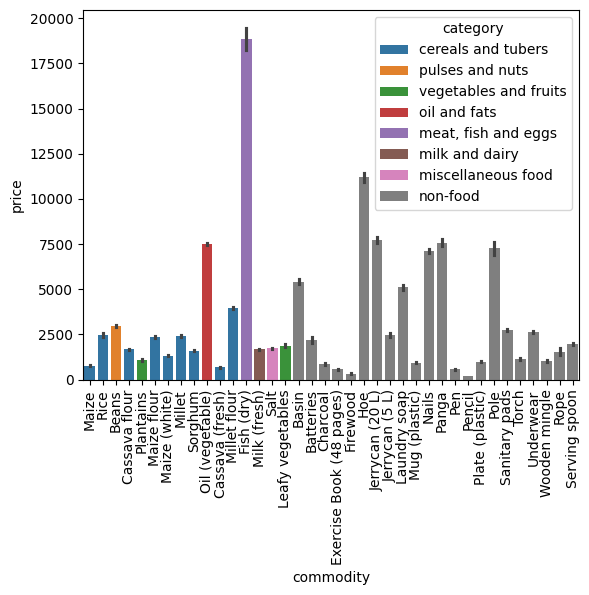

In [ ]:
#exploratory data viz
#using a barplot to understand the data and search for trends between the numeric and categorical features.
# Using seaborn to plot the group means by waistcircumference colored by tryglycerides

ax = sns.barplot(data=df, x="commodity", y="price", hue='category')
plt.xticks(rotation=90)
plt.show()



In [ ]:
df['date'] = pd.to_datetime(df['date'],errors='coerce')
df.head()


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
1,2006-01-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.40,0.1641
2,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
3,2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.40,0.5573
4,2006-01-15,Lira,Lira Municipality,Lira,2.235000,32.909722,cereals and tubers,Maize,KG,actual,Wholesale,UGX,247.76,0.1362
5,2006-02-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,UGX,296.59,0.1639


In [ ]:
## now that we remove NaT's let's make our datetime index
df = df.set_index('date')
df.head(3)


,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
date,,,,,,,,,,,,,
2006-01-15,Busia,Samia-bugwe,Busia,0.467000,34.090000,cereals and tubers,Maize,KG,actual,Wholesale,UGX,298.40,0.1641
2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Maize,KG,actual,Wholesale,UGX,345.42,0.19
2006-01-15,Kampala,Central Kampala,Owino,0.322805,32.574841,cereals and tubers,Rice,KG,actual,Wholesale,UGX,1013.40,0.5573


In [ ]:
df = df.sort_index()
df.index



DatetimeIndex(['2006-01-15', '2006-01-15', '2006-01-15', '2006-01-15',
               '2006-02-15', '2006-02-15', '2006-02-15', '2006-02-15',
               '2006-03-15', '2006-03-15',
               ...
               '2024-05-15', '2024-05-15', '2024-05-15', '2024-05-15',
               '2024-05-15', '2024-05-15', '2024-05-15', '2024-05-15',
               '2024-05-15', '2024-05-15'],
              dtype='datetime64[ns]', name='date', length=23254, freq=None)

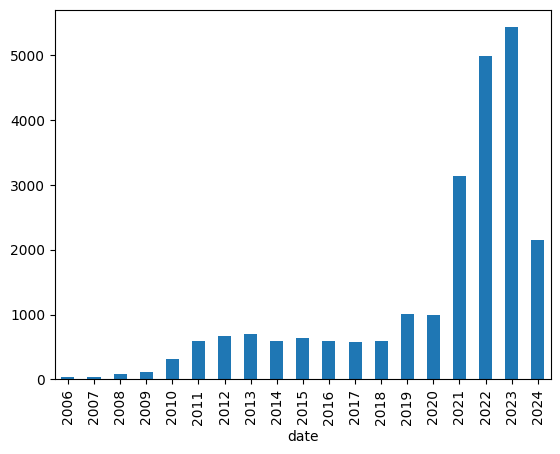

In [ ]:
years = df.index.year
years.value_counts().sort_index().plot(kind='bar');


<Axes: ylabel='category'>

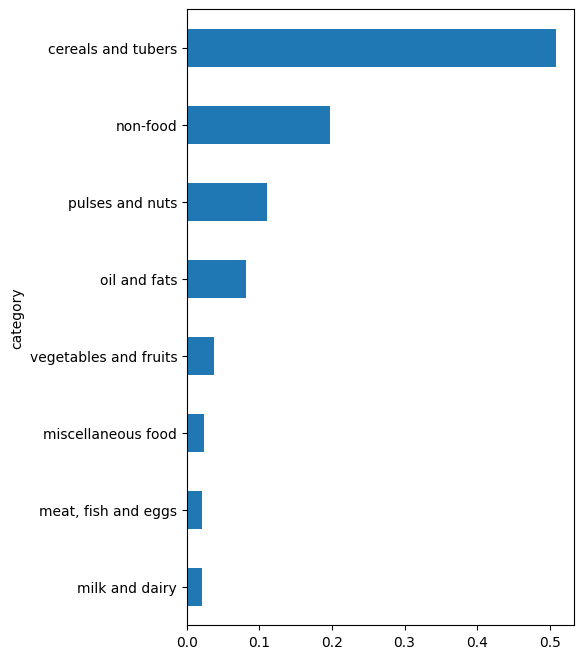

In [ ]:
## Inspect the value_counts for the different types of crimes
items_sold = df['category'].value_counts(normalize=True)
items_sold.sort_values().plot(kind='barh',figsize=(5,8))


In [ ]:
## Inspect the value_counts for the different types of crimes
items_sold = df['category'].value_counts().to_frame('Total # of items')
items_sold


,Total # of items
category,
cereals and tubers,11831
non-food,4576
pulses and nuts,2577
oil and fats,1902
vegetables and fruits,874
miscellaneous food,544
"meat, fish and eggs",482
milk and dairy,468


In [ ]:
## Inspect the value_counts for the different types of crimes
commodities = df['commodity'].value_counts().to_frame('Total # number of commodities')
commodities

,Total # number of commodities
commodity,
Beans,2577
Maize flour,2335
Maize (white),2211
Sorghum,2115
Oil (vegetable),1902
Cassava flour,1835
Millet,1378
Maize,736
Salt,544


In [ ]:
from os import PRIO_PROCESS
## Inspect the value_counts for the different types of crimes
prices = df['price'].value_counts().to_frame('Total #prices of items')
prices

,Total #prices of items
price,
2000.00,1415
1000.00,1028
3000.00,744
2500.00,668
1500.00,631
...,...
541.66,1
3488.44,1
2062.50,1
